In [4]:
import numpy as np

In [368]:
class Phys_model: 
    def __init__(self, A=None, B=None, C=None):
        self.__A = A
        self.__B = B
        self.__C = C
    
    def get_next_step(self, x_k, u_k):
        return (self.A.dot(x_k) + self.B.dot(u_k), C.dot(u_k))  
    
    #getters and setters
    @property
    def A(self):
        return self.__A
    
    @property
    def B(self):
        return self.__B
    
    @property
    def C(self):
        return self.__C


In [369]:
def print_debug(*args):
    str_to_print = ""
    for i, arg in enumerate(args):
        str_to_print = str_to_print + "Arg{num}: {arg}\t".format(num=i+1, arg=arg)
    print(str_to_print)

In [370]:
class KalmanFilter: 
    def __init__(self, phys_model, Q, H, P, K, R, z):
        self.__phys_model = phys_model
        self.__Q = Q
        self.__H = H
        self.__P = P
        self.__K = K
        self.__R = R
        self.__z = z
        
        self.__xk_opt = None
        self.__uk = None
        
    def __predict_project_error_covariance(self):
        a = self.__phys_model.A
        q = self.__Q
        p = self.__P
        self.__P = a.dot(p).dot(a.T) + q
    
    def __update_error_covariance(self):
        k = self.__K
        p = self.__P
        h = self.__H
        eye = np.eye(k.shape[0])
        self.__P = (eye - k.dot(h)).dot(p)
    
    def __compute_kalman_gain(self):
        p = self.__P
        h = self.__H
        r = self.__R
        tmp = (h.dot(p).dot(h.T) + r)
        try: 
            tmp = h.dot(p).dot(h.T) + r
            tmp = np.linalg.inv(tmp)
        except np.linalg.linalg.LinAlgError:
            tmp = np.zeros(tmp.shape)
            
        self.__K = p.dot(h.T).dot(tmp)
    
    def __compute_xk_opt(self, xk, k):
        self.__xk_opt = xk + self.__K.dot(self.__z[k] - self.__H.dot(xk))
    
    def do_filtration(self, n_steps, xk_initial, uk_initial):
        self.__xk_opt = xk_initial
        self.__uk = uk_initial
        
        res = []
        
        for i in range(n_steps):
            (xk, self.__uk) = self.__phys_model.get_next_step(self.__xk_opt, self.__uk)
            self.__predict_project_error_covariance()
            self.__compute_kalman_gain()
            self.__compute_xk_opt(xk, i)
            self.__update_error_covariance()
            
            res.append(self.__xk_opt)
            
        return np.array(res)
    
    #getters and setters    
    @property
    def P(self):
        return self.__P
    
    #!TODO: write adequate setter
#     @P.setter
#     def P(self, P):
#         self.__P = P
    
    @property
    def K(self):
        return self.__K
    
    
    #!TODO: write adequate setter
#     @z.setter
#     def z(self, z):
#         self.__z = z


### Model 1

In [371]:
A = np.array([[1]])
B = np.array([[1]])
C = np.array([[1]])

model = Phys_model(A, B, C)

In [372]:
xk = np.array([[1]])
uk = np.array([[1]])
observations = [xk]
for i in range(100 - 1):
    (xk, uk) = model.get_next_step(xk, uk)
    observations.append(xk)

observations = np.array(observations)
observations_with_noise = observations + np.random.normal(0, 3, 100).reshape(100, 1, 1)

In [373]:
Q = np.array([[0.1]])
H = np.array([[1]])
P = np.array([[1]])
K = np.array([[2]])
R = np.array([[2]])
z = observations_with_noise

filter = KalmanFilter(model, Q, H, P, K, R, z)

In [374]:
filter = KalmanFilter(model, Q, H, P, K, R, z)

In [375]:
xk = np.array([[1]])
uk = np.array([[1]])

res = filter.do_filtration(50, xk, uk)

In [376]:
obs_reshaped = observations.reshape(observations.shape[0],)
obs_wn_reshaped = observations_with_noise.reshape(observations_with_noise.shape[0],)
res_reshaped = res.reshape(res.shape[0],)

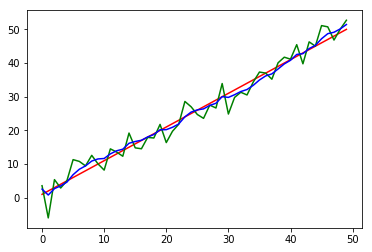

In [377]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(0.0, 50, 1)

plt.plot(t, obs_reshaped[:50], 'r')
plt.plot(t, obs_wn_reshaped[:50], 'g')
plt.plot(t, res_reshaped[0:50], 'b')
plt.show()

Green - ground truth

Red - observation with noise

Blue - Kalman filter

### Model 2

In [295]:
A = np.array([[0.3, 1.1], [0.9, 0]])
B = np.array([[0], [0]])
C = np.array([[0]])

model = Phys_model(A, B, C)

In [296]:
xk = np.array([[1],[0.3]])
uk = np.array([[0]])
observations = [xk]
for i in range(100 - 1):
    (xk, uk) = model.get_next_step(xk, uk)
    observations.append(xk)

observations = np.array(observations)
cov = np.array([[1, 0],
                [0, 2]])
observations_with_noise = observations + np.random.multivariate_normal([0, 0], cov, 100).reshape(100, 2, 1)

In [297]:
R = np.array([[1, 0],
             [0, 1.7]])
H = np.array([[1, 0],
              [0, 1]])
P = np.array([[1, 0],
              [0, 1]])
K = np.array([[1, 0],
              [0, 1]])
Q = np.array([[1, 0],
              [0, 1.1]])
z = observations_with_noise

filter = KalmanFilter(model, Q, H, P, K, R, z)

In [298]:
xk = np.array([[1],[0.3]])
uk = np.array([[0]])

re = filter.do_filtration(30, xk, uk)

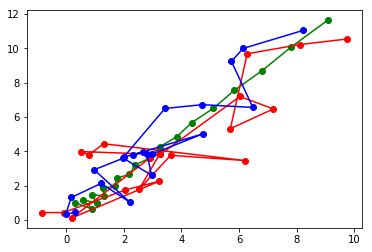

In [302]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(observations[:20, 1], observations[:20, 0], 'go-')
plt.plot(observations_with_noise[:20, 1], observations_with_noise[:20, 0], 'ro-')
plt.plot(re[0:20, 1], re[1:21, 0], 'bo-')
plt.show()

Green - ground truth

Red - observation with noise

Blue - Kalman filter